In [1]:
import numpy as np
import pandas as pd

## Gene co-expression network

A gene co-expression network (GCN) is an undirected graph, where each node corresponds to a gene, and a pair of nodes is connected with an edge if there is a significant co-expression relationship between them.

In this context we want to link only those genes that are directly dependent from one another and not linked through a third gene. 

In the state of the art you may find several methods for the inference of graphs based on different concepts. Today we are going to see **Algorithm for the Reconstruction of Accurate Cellular Networks** (ARACNe)

### Loading data
Load the files `"gedm.csv"` and `"labels.csv"`.

In [2]:
data = pd.read_csv("gedm.csv", index_col=0)
labels = pd.read_csv("labels.csv", index_col=0)

#### Remove rows that start with AFFX and select a sub-matrix

In [3]:
data.drop(data.index[data.index.str.startswith('AFFX')], inplace=True)
X = data.iloc[np.random.randint(0, data.shape[0], 30), :].values.T

# ARACNe

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-S1-S7

It is a method for the reverse engineering of transcriptional networks. It defines an edge between two gene expression profiles as an *irreducible statistical dependency* that cannot be explained as an artifact or other statistical dependencies in the network.

The joint probability distribution over the genes is defined as 
<img src="jpd.png"/>
where $Z$ is a normalization factor, $N$ is the number of genes and $\Phi$ are the potentials. In the model we say that two variables interact iff their potential is nonzero. 

The estimation of the network is done through 3 main steps:

    1) computation of pairwise mutual information
    2) statistical threshold for mutual information
    3) data processing inequality

## Computation of pairwise mutual information
The mutual information $I(g_i, g_j) = I_{ij}$ is an information-theoretic measure of relatedness that is zero iff $P(g_i, g_j) = P(g_i)P(g_j)$ i.e., if the genes $g_i$ and $g_j$ are independent. 

The mutual information is defined, for a pair of random variables $x$ and $y$ as $I(x,y) = S(x) + S(y) - S(x,y)$ where $S(t)$ is the *entropy*.

The entropy of a random variable t is defined as: 


<center>$\Large{S(t) = - \mathbb{E}[\text{log}p(t)] = - \sum\limits_{i}p(t_i)\text{log}(p(t_i))}$</center>

with $p(t_i)$ is the probability of each discrete state of the variable.

Therefore
<center>$\Large{I(g_i,g_j)=I_{ij}=\sum\limits_{h,k}p(g_{ih},g_{jk})log\bigg{[}\frac{p(g_{ih},g_{jk})}{p(g_ih)p(g_jk)}\bigg{]}}$</center>.

This measure can be generalized to the continuous case easily. 
Mutual information is guaranteed to be nonzero iff any kind of statistical dependence exists. 

Above definitions are well defined for discrete data and probability mass functions. When dealing with **continuous random variables** (as *microarray data*) we need to realiably estimate the density function from data in order to be able to compute the mutual information between each pair of genes.

**Kernel Density Estimation (KDE)** is a nonparametric method for estimating probability densities.

We can approximate the underlying density of our data by computing,

<center>$\Large{\hat{p}(x)=\frac{1}{n}\sum\limits_{i}^H\mathbf{K}(u)}$,</center>

where $\large{u=\frac{(x-x_i)^TS^{-1}(x-x_i)}{h^2}}$, $\mathbf{K}(u)$ is a multivariate kernel function, $x=[x_1,\dots,x_d]^T$ is the $d$-dimensional random vector whose density is being estimated, $x_i=[x_{i1},\dots,x_{in}]^T$ with $i=1,\dots,n$ are the n sample vectors, $h$ is the kernel bandwidth, $S$ is the covarinace matrix of the observations $x_i$ and $H$ prescribes the range of data over which the average is computed.

We use the multivariate Gaussian probability density function for the kernel function $\mathbf{K}(u)$ which is given by 


<center>$\large{\mathbf{K}(u)=\frac{1}{(2\pi)^{\frac{d}{2}}h^d det(S)^{\frac{1}{2}}}exp(-\frac{u}{2})}$</center>

**In `utils.py` you may find already defined functions for the kernel density estimation of the joint probability denisty function (`p_mkde_M`), the marginals (`p_kde`) and for the approximation of mutual information using kernel estimations (`kernel_mi`).**

**Use these functions to compute the $N_{genes}\times N_{genes}$ mutual information matrix (MI) from your data**

In [4]:
from utils import kernel_mi
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
def compute_mutual_information(X):
    #Insert your code here
    MI = np.zeros((X.shape[1], X.shape[1]))
    for i in np.arange(X.shape[1]):
        for j in np.arange(X.shape[1]):
            if (i!=j):
                MI[i][j] = kernel_mi(X[:, i], X[:, j])          
    return MI

MI = compute_mutual_information(X)

**Visualize the Gene expressions and the mutual information**

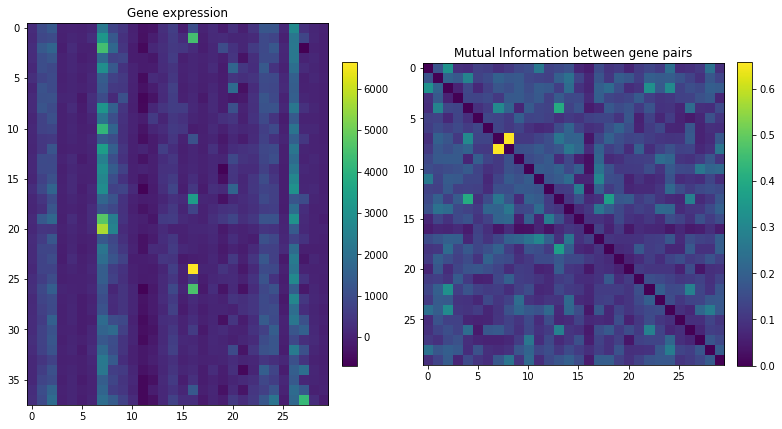

In [6]:
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(X,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Gene expression')

plt.subplot(122)
plt.imshow(MI,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Mutual Information between gene pairs');

## Statistical threshold for mutual information

Since MI is always non-negative its evaluation gives positive values even for variables that are mutually independent. Therefore we need to eliminate those edges for which there is no evidence against the hypothesis of mutual independence (the null hypothesis).

We want to obtain a statistical threshold $I_0$ on computed mutual informations able to identify those connections that do not actually exist.
To this extent, fixed a p-value, consider a set of genes and a **bilateral statistical test** of samples independence.

We use as test statistic the mutual information between pairs of genes. In order to compute the p-value we should know the distribution of mutual informations under the null-hypothesis, since the p-value is defined as

<center>$\large{p_{H_0}(I>=I_0)}$.</center>

Nevertheless, we do not know the distribution of mutual information on independent variables. We need to perform **Monte Carlo** simulations on independent data in order to obtain an approximate distribution of MIs. We do this by shuffling the genes across the profiles and evaluate the MI of these manifestly independent genes.


We then compute the threshold based on our confidence.

**Visualize the distribution of observed mutual informations on our data**

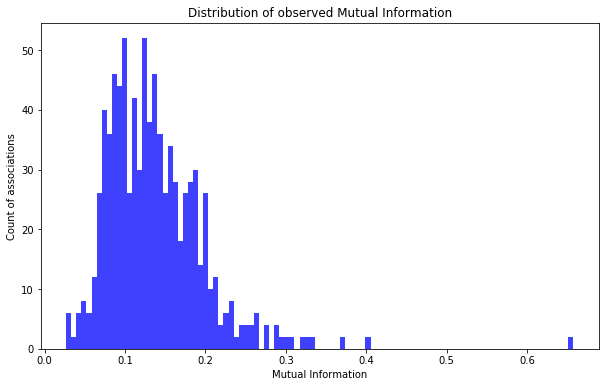

In [7]:
aux = np.ndarray.flatten(MI)
idxx = np.where(aux != 0)
MI_list = np.ndarray.tolist(aux[idxx])

#Plot
plt.figure(figsize=(10, 6))
bins = np.linspace(min(MI_list), max(MI_list), 101)
plt.hist(MI_list, bins, facecolor='b',alpha=0.75)
plt.xlabel('Mutual Information')
plt.ylabel('Count of associations')
plt.title('Distribution of observed Mutual Information');

**Fill the function below aimed to compute the mutual information on different permutations of data**

In [8]:
def permutated_MI(X, N_perm):
    #Insert your code here
    MI_perm = np.zeros((X.shape[1], X.shape[1], N_perm))
    for n in np.arange(N_perm):
        shuffled_X = np.copy(X)
        for k in np.arange(X.shape[1]):
            np.random.shuffle(shuffled_X[:, k])
        for i in np.arange(X.shape[1]):
            for j in np.arange(X.shape[1]):
                if (i!=j):
                    MI_perm[i][j][n] = kernel_mi(shuffled_X[:, i], shuffled_X[:, j])   
    return MI_perm

In [9]:
MI_perm = permutated_MI(X, N_perm=1) 
MI_perm = np.ndarray.flatten(MI_perm)
idx = np.where(MI_perm != 0)
MI_list2 = np.ndarray.tolist(MI_perm[idx])

**Visualize the data empirical distribution together with the approximated empirical distribution of independent samples. What can you observe?**

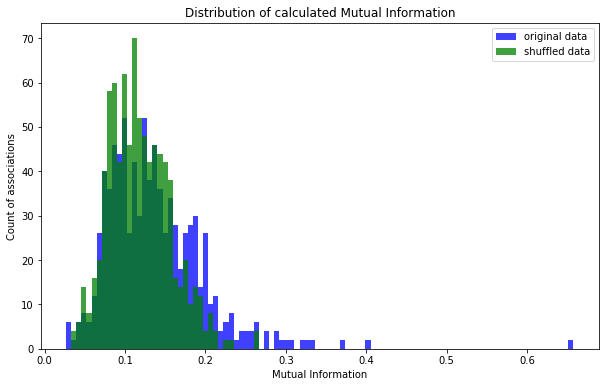

In [10]:
#Plot
plt.figure(figsize=(10, 6))

plt.hist(MI_list, bins,facecolor='b', alpha=0.75,label='original data')
plt.hist(MI_list2, bins,facecolor='g', alpha=0.75,label='shuffled data')
plt.legend(loc='upper right')

# plt.axvline(np.amax(matMI_alternative),c='r',linewidth=4)
plt.xlabel('Mutual Information')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated Mutual Information');

From what concerns the term "shuffling the genes across profiles", and from previous discussions on MS teams, I understood that we should shuffle permute the values of each column separately. If we do so, then we are destroying every possibile correlation between the variables corresponding to the gene expressions, because we are swapping values separately in each column and therefore the obtained results of column $x_i$ may not be coherent, within the same row, with the ones that we should have in column $x_j$ to have at least some degree of relationship between the variables. We are doing so to visualize the distribution of mutual information with respect to independent variables.


We can observe, from the above plot, that perfoming such operations when computing the permuted mutual information gives us a smaller cardinality of the associations corresponding to non-zero mutual information, and that the associations which had the greatest mutual information values in the mutual information matrix associated to unmodified data have been removed. This confirms the effect of the approach described above.

**Let's compute the empirical complementary cumulative distribution function of the synthetic data
and compute the threshold based on a fixed significance level p**

In [11]:
p_value = 0.1

def eccd(synth_data,data):
    #Insert your code here
    f_values = np.sort(np.unique(synth_data), axis=None)
    tot = synth_data.shape[0]
    #vector of probabilities
    p_vec = np.zeros(f_values.shape[0])
    for idx, f in enumerate(f_values):
        p_vec[idx] = np.count_nonzero(synth_data >= f)/tot
    
    emp_eccd = np.zeros(len(data))

    for idx, m_i in enumerate(data):
        pgt_m_i = p_vec[f_values >= m_i]
        if (pgt_m_i.shape[0]==0):
            emp_eccd[idx] = 0
        else:       
            emp_eccd[idx] = pgt_m_i[0]
    return emp_eccd

**Visualize the empirical complememtary cumulative distribution function on data defined below. Is it coherent with what you expected?**

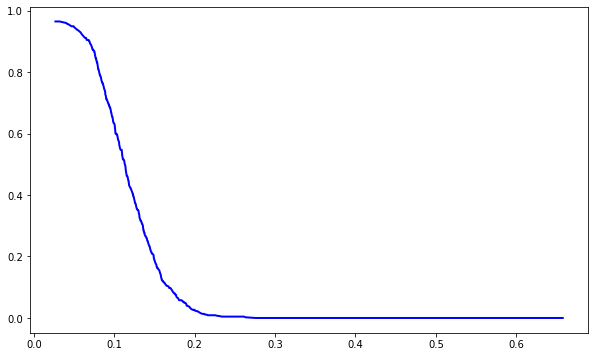

In [12]:
data = np.sort(MI_list) 
plt.figure(figsize=(10,6))
plt.plot(data,eccd(MI_perm,data),lw = 2,color='b')

**We compute the statistical threshold by looking for the value of the synthetic data for which the probability
of observing values greater than that is less or equal than p**

In [13]:
data = np.unique(np.sort(MI_perm))
observed_eccd = eccd(MI_perm,data)

Compute the statistical threshold $I_0$

In [14]:
I_0 = np.amin(data[observed_eccd <= p_value])

In [15]:
print('Statistical threshold: %s' % I_0)

Statistical threshold: 0.16817739953568717


**Visualize the data empirical distribution together with the approximated empirical distribution of independent sample and the estimated statistical threshold. What can you obseerve?**

Maximum MI value for the shuffled matrix: 0.26628921974927905


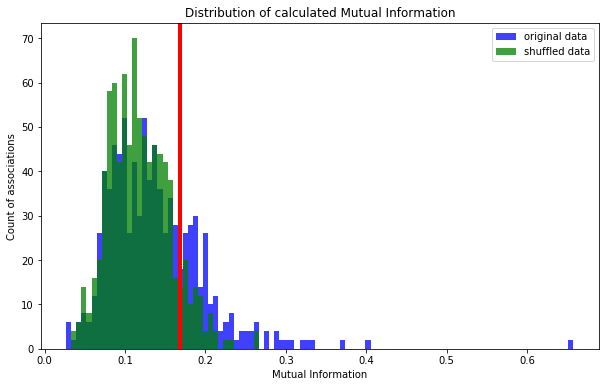

In [16]:
#Plot
plt.figure(figsize=(10, 6))

plt.hist(MI_list, bins,facecolor='b', alpha=0.75,label='original data')
plt.hist(MI_list2, bins,facecolor='g', alpha=0.75,label='shuffled data')
plt.legend(loc='upper right')

plt.axvline(I_0,c='r',linewidth=4)
plt.xlabel('Mutual Information')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated Mutual Information');

print('Maximum MI value for the shuffled matrix: {}'.format(np.max(MI_perm)))

**Use `plt.imshow` to visualize the MI matrix with and without sparsity induced by the threshold** 

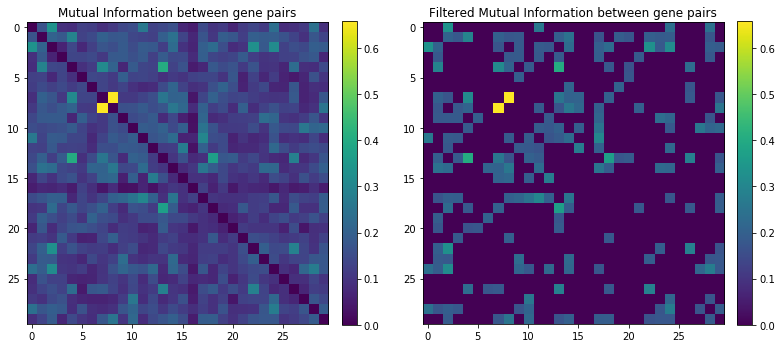

In [17]:
MI_filtered = np.where(MI <= I_0, 0, MI)#The mutual information matrix with edges removed cause of the sparisty induced by the statistical threshold


#Plot
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(MI,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Mutual Information between gene pairs');

plt.subplot(122)
plt.imshow(MI_filtered,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Filtered Mutual Information between gene pairs');


## Data processing inequality (DPI)

We want to exclude those genes that are connected through a third gene. We now that if the genes $g_1$ and $g_3$ are connected through $g_2$ then

$I(g_1, g_3) \leq \text{min}\bigg(I(g_1, g_2), I(g_2, g_3)\bigg)$

therefore we look at all the triplets of genes in the resulting matrix of the previous step and we eliminate those edges that respects this inequality. 

**Define a function able to detect the smallest mutual information between a triplets and remove the corresponding edge in the final graph**

In [18]:
def filter_cycles(MI_filtered):
    
    MI_final = np.copy(MI_filtered)
    pair_list = [(i, j) for i in np.arange(MI_filtered.shape[1]) for j in np.arange(MI_filtered.shape[1]) if i!=j]
    triplets_list = [(pair[0], pair[1], k) for pair in pair_list for k in np.arange(MI_filtered.shape[1]) if pair[0]!=pair[1] and pair[1]!=k and pair[0]!=k]
    for triplet in triplets_list:
        if (MI_final[triplet[0]][triplet[2]] <= \
            np.amin([MI_final[triplet[0]][triplet[1]], MI_final[triplet[1]][triplet[2]]])):
            MI_final[triplet[0]][triplet[2]] = 0
        elif (MI_final[triplet[0]][triplet[1]] <= MI_final[triplet[1]][triplet[2]]):
            MI_final[triplet[0]][triplet[1]] = 0
        else:
            MI_final[triplet[1]][triplet[2]] = 0
    return MI_final

**Use `plt.imshow` to visualize the MI matrices with and without sparsity induced by the threshold and DPI** 

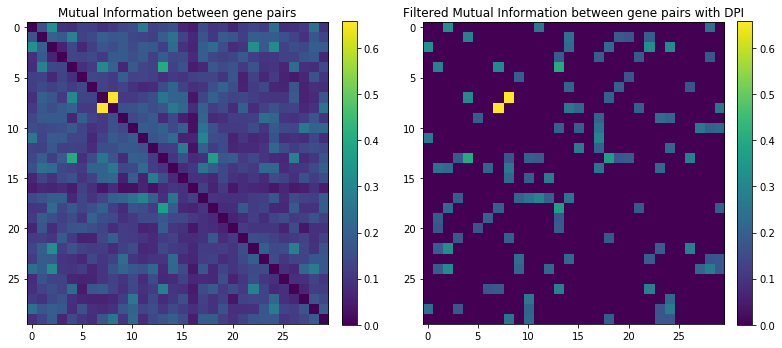

In [19]:
#Plot
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(MI,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Mutual Information between gene pairs');

plt.subplot(122)
plt.imshow(filter_cycles(MI_filtered),interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Filtered Mutual Information between gene pairs with DPI');


# Synthetic experiment

**We evaluate the previous pipeline for the inference of regulatory networks from gene expression data comparing the inferred network with a 'syntehtic' one. The synthetic one is obtained by simulating sort of metabolic processes, based on sets of coupled differential equations. To fully define a gene network model it is also necessary to create a network topology, or wiring diagram. Past research in gene networks has concentrated on a particular topological class: random gene networks. These random networks follow a topology studied earlier by mathematicians Erdo ̈s and Re ́nyi, where each vertex of a graph is equally likely to be connected to any other vertex in the graph.**

**We obtained a dataset compatible with the above description at the `Artificial Gene Network Series Century`[http://www.comp-sys-bio.org/AGN/Century/]**

In [20]:
#Load the gene expression data

df = pd.read_csv('CenturyRND.csv',sep='\t')
df = pd.DataFrame(df)
df.columns = ['G'+str(i) for i in range(1,101)]

In [21]:
df.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G91,G92,G93,G94,G95,G96,G97,G98,G99,G100
0,0.000000,0.000202,7.9741,0.001117,0.002229,0.000248,1.1553,2.8368,0.003304,0.002131,...,0.000566,0.00093,2.9038,0.000196,9.421700e-07,7.9384,0.000176,7.9014,0.000125,2.8212
1,0.007688,0.000000,7.9741,0.001117,0.002229,0.000248,1.1553,2.8368,0.003304,0.002131,...,0.000566,0.00093,2.9038,0.000196,9.421700e-07,7.9384,0.000176,7.9014,0.000125,2.8212
2,0.007688,0.000202,0.0000,0.001117,0.002229,0.000248,1.1553,2.8368,0.003304,0.002131,...,0.000566,0.00093,2.9038,0.000196,9.421700e-07,7.9384,0.000176,7.9014,0.000125,2.8212
3,0.007666,0.000202,7.9741,0.000000,0.002228,0.000248,1.1190,2.8368,0.003285,0.002235,...,0.000566,0.00093,2.9033,0.000169,7.806900e-07,7.9385,0.000176,7.9017,0.000125,2.8212
4,0.004927,0.000202,7.9741,0.001117,0.000000,0.000248,1.1553,2.8367,0.003304,0.002131,...,0.000566,0.00093,2.9038,0.000196,9.421700e-07,7.9384,0.000176,7.9014,0.000125,2.8212


**Load the network edges**

In [22]:
edges = pd.read_csv('CenturyRND-net.csv', sep=' ')
edges = pd.DataFrame(edges)
edges = edges[['Node1','Node2']]
edges.head()

,Node1,Node2
0,57,1
1,53,1
2,28,2
3,56,2
4,84,3


**Let's build the network with `networkx` and obtain the adjacency matrix**

In [23]:
import networkx as nx

edges_ground_truth = edges.values
ground_net = nx.Graph()
ground_net.add_nodes_from([i for i in range(1,101)])
ground_net.add_edges_from(edges_ground_truth)
adj_ground_net = nx.adjacency_matrix(ground_net).todense()

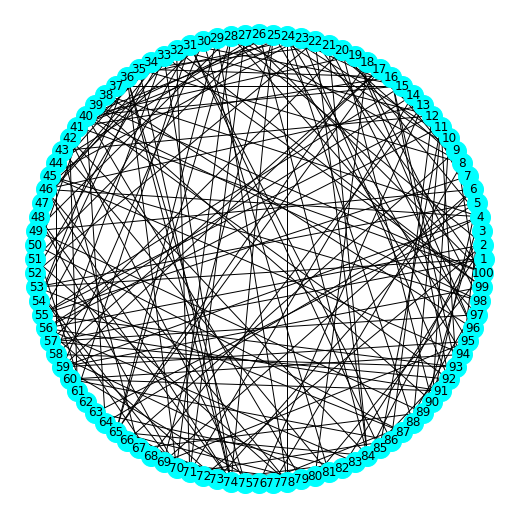

In [24]:
plt.figure(figsize = (7,7))
nx.draw_circular(ground_net,with_labels=True, node_size=400, node_color='cyan',)

Text(0.5, 1.0, 'Adjacency matrix of the ground-truth network')

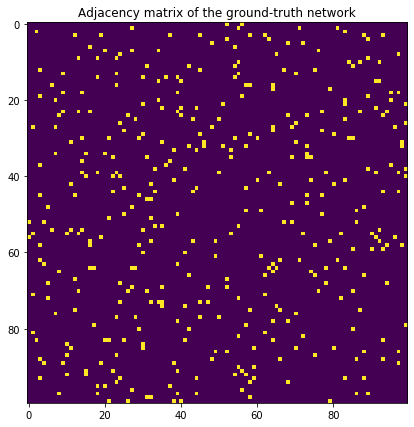

In [25]:
plt.figure(figsize=(7,7))
plt.imshow(adj_ground_net)
plt.title("Adjacency matrix of the ground-truth network")

**Use ARACNe method for inferring the network. Refer to the previous pipeline. We have already computed the matrices MI and MI_perm since their computation is pretty expensive. You just need to load them as `np.array`**

**Define a function able to recover the undirected network from the inferred mutual information matrix and find a way to compare the obtained adjacency matrix with the ground-truth in order to evaluate the inference result.**

In [26]:
from numpy import load

MI = load('MI.npy')
MI_perm = load('MI_perm.npy')

for i in np.arange(MI.shape[0]):
    for j in np.arange(i+1, MI.shape[1]):
        MI[j, i] = MI[i, j] 

In [27]:
data = np.unique(np.sort(MI_perm))
observed_eccd = eccd(MI_perm,data)

In [28]:
p_value = 0.1

In [29]:
I_0 = np.amin(data[observed_eccd <= p_value])

In [30]:
print('Statistical threshold: %s' % I_0)

Statistical threshold: 0.038518648880846544


In [31]:
MI_filtered = np.where(MI <= I_0, 0, MI)
dpi_filtered_matrix = filter_cycles(MI_filtered)
adjacency_matrix_from_MI = np.where(dpi_filtered_matrix > 0, 1, 0)

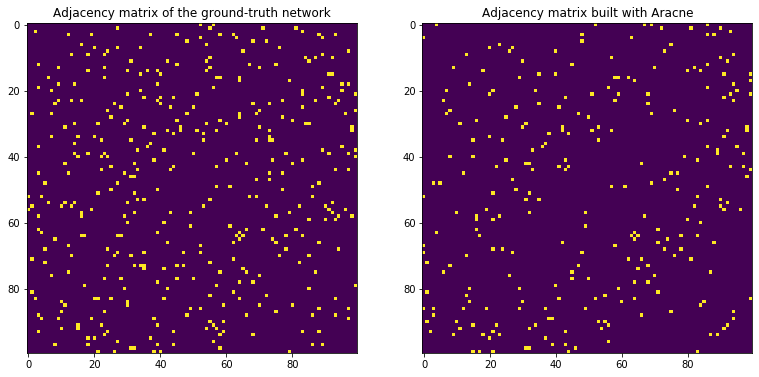

In [32]:
#Plot
plt.figure(figsize=(13, 13))
plt.subplot(121)
plt.imshow(adj_ground_net)
plt.title("Adjacency matrix of the ground-truth network")

plt.subplot(122)
plt.imshow(adjacency_matrix_from_MI)
plt.title('Adjacency matrix built with Aracne');


In [33]:
def compute_qtys_needed(y_pred, y, class_labels):
    pos_class = class_labels[class_labels > 0]
    neg_class = class_labels[class_labels <= 0]
    pos_y_idx = y == pos_class
    neg_y_idx = y == neg_class
    pos_y_pred_idx = y_pred == pos_class
    neg_y_pred_idx = y_pred == neg_class
    TP = np.count_nonzero(y_pred[pos_y_idx] == pos_class)
    TN = np.count_nonzero(y_pred[neg_y_idx] == neg_class)
    FP = np.count_nonzero(y[pos_y_pred_idx] == neg_class)
    FN = np.count_nonzero(y[neg_y_pred_idx] == pos_class)
    return TP, TN, FP, FN

def calc_accuracy(y_pred, y, class_labels):
    TP, TN, FP, FN = compute_qtys_needed(y_pred, y, class_labels)
    return (TN + TP)/(float(TN + TP + FP + FN))
    
    
def calc_balanced_accuracy(y_pred, y, class_labels):
    TP, TN, FP, FN = compute_qtys_needed(y_pred, y, class_labels)
    return (float(TP / (TP + FN)) + float(TN / (TN + FP)))/2
    


In [34]:
print ("The percentage of different edges is ",  calc_accuracy(adj_ground_net, adjacency_matrix_from_MI, np.array([0, 1]))*100)

The percentage of different edges is  95.89999999999999


**MRNET**

In [35]:
def MRNET_scores(X, permutated=False, pre_computed_MI=None):
    if (pre_computed_MI is None):
        if (permutated):
            MI = permutated_MI(X, N_perm=1)
        else:
            MI = compute_mutual_information(X)
    else:
        MI = pre_computed_MI
    score_matrix = np.zeros(MI.shape)
    for y in np.arange(MI.shape[1]): 
        S_y_col = []
        S_y_row = []
        for i in np.arange(MI.shape[0]):
            S_y_col_idxs = list(set(np.arange(MI.shape[0]))-set(S_y_col))
            S_y_row_idxs = list(set(np.arange(MI.shape[1]))-set(S_y_row))
            s_j_values_y_col = [] 
            s_j_values_y_row = []
            for j in S_y_col_idxs:
                if (j!=y):
                    u_j = MI[j, y]
                    if (S_y_col!=[]):
                        m_i_mean = np.mean(MI[j, S_y_col])
                        s_j = u_j - m_i_mean
                    else:
                        s_j = u_j
                else:
                    s_j = 0
                s_j_values_y_col.append(s_j)
            sel_val_idx_y_col = S_y_col_idxs[np.argmax(s_j_values_y_col)]
            S_y_col.append(sel_val_idx_y_col)
            for j in S_y_row_idxs:
                u_j = MI[y, j]
                if (S_y_row!=[]):
                    m_i_mean = np.mean(MI[S_y_row, j])
                    s_j = u_j - m_i_mean
                else:
                    s_j = u_j
                s_j_values_y_row.append(s_j)
            sel_val_idx_y_row = S_y_row_idxs[np.argmax(s_j_values_y_row)]
            S_y_row.append(sel_val_idx_y_row)
            for j in list(set(S_y_col_idxs).intersection(S_y_row_idxs)):
                idx = S_y_row_idxs.index(j)
                idx2 = S_y_col_idxs.index(j)
                max_i_j = np.amax([s_j_values_y_row[idx], s_j_values_y_col[idx2]])
                score_matrix[j, y] = max_i_j
                score_matrix[y, j] = max_i_j
            
    return score_matrix

In [36]:
score_matrix = MRNET_scores(X)

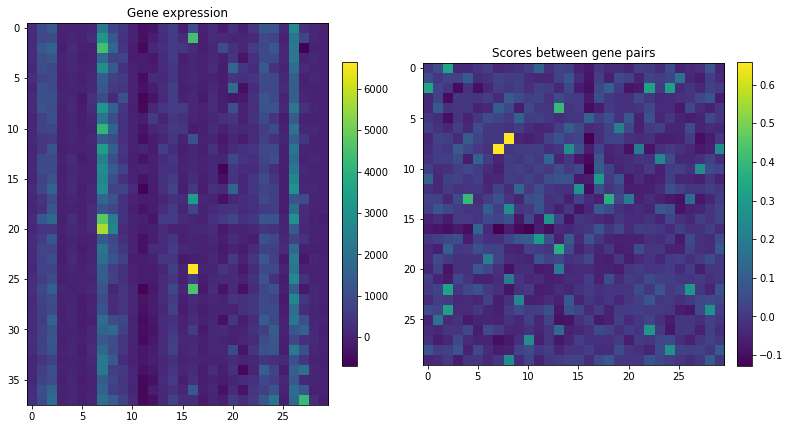

In [37]:
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(X,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Gene expression')

plt.subplot(122)
plt.imshow(score_matrix,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Scores between gene pairs');

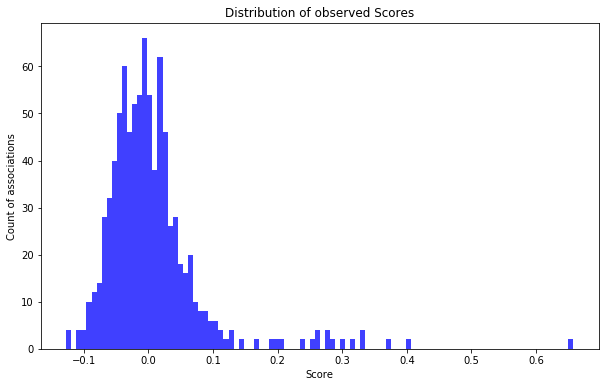

In [38]:
aux = np.ndarray.flatten(score_matrix)
idxx = np.where(aux != 0)
score_list = np.ndarray.tolist(aux[idxx])

#Plot
plt.figure(figsize=(10, 6))
bins = np.linspace(min(score_list), max(score_list), 101)
plt.hist(score_list, bins, facecolor='b',alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Count of associations')
plt.title('Distribution of observed Scores');

In [39]:
score_matrix_perm = MRNET_scores(X, True)
score_matrix_perm = np.ndarray.flatten(score_matrix_perm)
idx = np.where(score_matrix_perm != 0)
score_list_2 = np.ndarray.tolist(score_matrix_perm[idx])

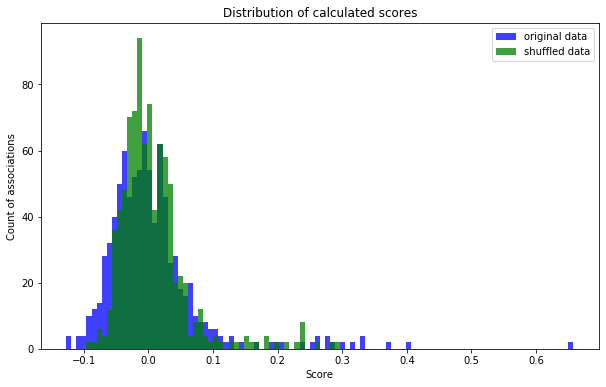

In [40]:
#Plot
plt.figure(figsize=(10, 6))

plt.hist(score_list, bins,facecolor='b', alpha=0.75,label='original data')
plt.hist(score_list_2, bins,facecolor='g', alpha=0.75,label='shuffled data')
plt.legend(loc='upper right')

plt.xlabel('Score')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated scores');

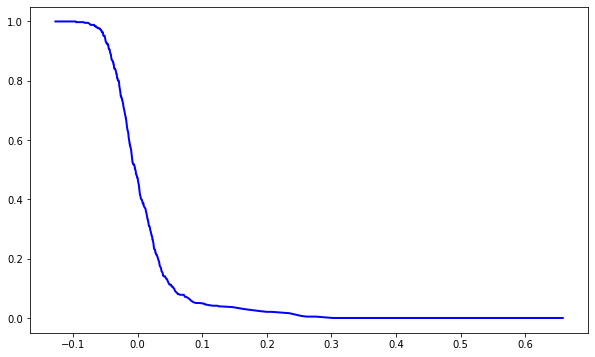

In [41]:
data = np.array(np.sort(score_list))
plt.figure(figsize=(10,6))
plt.plot(data,eccd(np.array(score_list_2),data),lw = 2,color='b')

In [42]:
data = np.unique(np.sort(score_list_2))
observed_eccd = eccd(np.array(score_list_2), data)

In [43]:
I_0 = np.amin(data[observed_eccd <= p_value])

In [44]:
print('Statistical threshold: %s' % I_0)

Statistical threshold: 0.05645645808461336


Maximum score value for the matrix corresponding to the shuffled MI: 0.2909106418987568


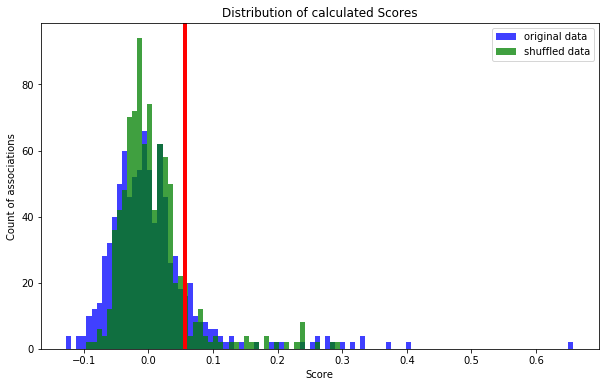

In [45]:
#Plot
plt.figure(figsize=(10, 6))

plt.hist(score_list, bins,facecolor='b', alpha=0.75,label='original data')
plt.hist(score_list_2, bins,facecolor='g', alpha=0.75,label='shuffled data')
plt.legend(loc='upper right')

plt.axvline(I_0,c='r',linewidth=4)
plt.xlabel('Score')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated Scores');

print('Maximum score value for the matrix corresponding to the shuffled MI: {}'.format(np.max(score_list_2)))

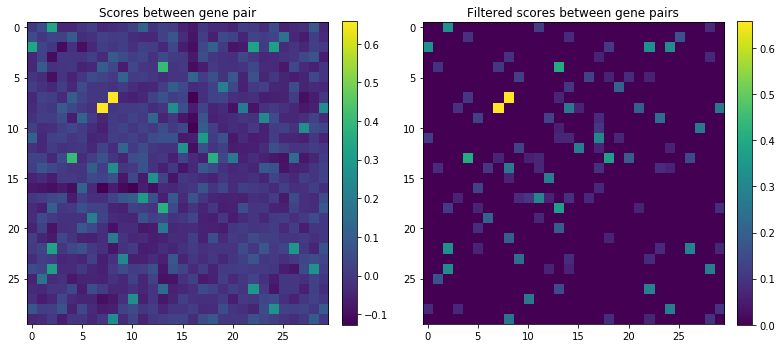

In [46]:
scores_filtered = np.where(score_matrix <= I_0, 0, score_matrix) 


#Plot
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(score_matrix,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Scores between gene pair');

plt.subplot(122)
plt.imshow(scores_filtered,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Filtered scores between gene pairs');


**Synthetic experiment for MRNET**

In the following cell, I compute again the two matrices from the dataset loaded in the dataframe df. The cell takes 3-4 hours to run, as expected from the fact that it is preferable to load the matrices from the .npy files. I did this again because I wanted to compute the permutations over the original dataset, since the MI_perm matrix provided to us is a flattened matrix (a vector). I repeated the procedure seen for the scores computed on the random dataset seen in the previous examples: I used the threshold that we obtain by re-computing again MI_perm and by keeping the original shape (100, 100).

In [47]:
score_matrix = MRNET_scores(np.array(df), False)
print ("score_matrix computed successfully!")
score_matrix_perm = MRNET_scores(np.array(df), True)
print ("score_matrix_perm computed successfully!")


score_matrix computed successfully!
score_matrix_perm computed successfully!


In [48]:
score_matrix_perm_flat = np.ndarray.flatten(score_matrix_perm)
idx = np.where(score_matrix_perm_flat != 0)
score_list_2 = np.ndarray.tolist(score_matrix_perm_flat[idx])
score_matrix_flat = np.ndarray.flatten(score_matrix)
idx = np.where(score_matrix_flat != 0)
score_list = np.ndarray.tolist(score_matrix_flat[idx])
data = np.unique(np.sort(score_list_2))
observed_eccd = eccd(np.array(score_list_2),data)

In [49]:
p_value = 0.1

In [50]:
I_0 = np.amin(data[observed_eccd <= p_value])

In [51]:
print('Statistical threshold: %s' % I_0)

Statistical threshold: 0.010231285775446249


In [52]:
score_matrix_filtered = np.where(score_matrix <= I_0, 0, score_matrix)
adjacency_matrix_from_scores = np.where(score_matrix_filtered > 0, 1, 0)

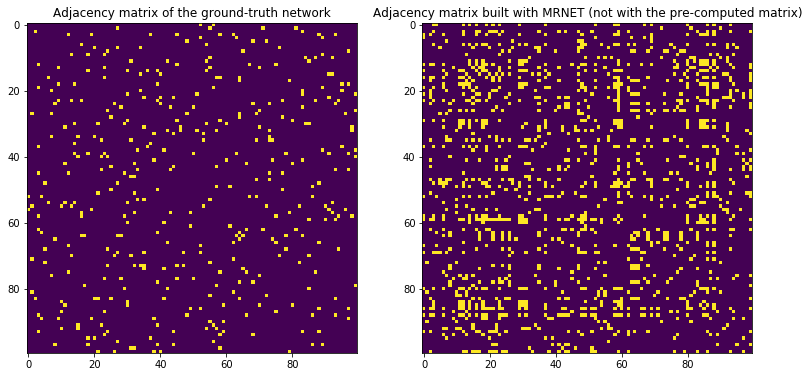

In [53]:
#Plot
plt.figure(figsize=(13, 13))
plt.subplot(121)
plt.imshow(adj_ground_net)
plt.title("Adjacency matrix of the ground-truth network")

plt.subplot(122)
plt.imshow(adjacency_matrix_from_scores)
plt.title('Adjacency matrix built with MRNET (not with the pre-computed matrix)');


In [54]:
print ("The percentage of different edges is ",  calc_accuracy(adj_ground_net, adjacency_matrix_from_scores, np.array([0, 1]))*100)

The percentage of different edges is  87.36


In [55]:
score_matrix_from_read_MI = MRNET_scores(np.array(df), False, MI)

In [56]:
score_matrix_filtered_read_MI = np.where(score_matrix_from_read_MI <= I_0, 0, score_matrix)
adjacency_matrix_from_scores_read_MI = np.where(score_matrix_filtered_read_MI > 0, 1, 0)

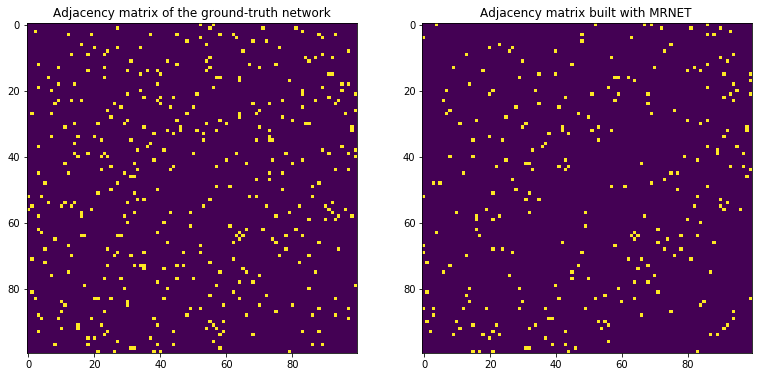

In [57]:
#Plot
plt.figure(figsize=(13, 13))
plt.subplot(121)
plt.imshow(adj_ground_net)
plt.title("Adjacency matrix of the ground-truth network")

plt.subplot(122)
plt.imshow(adjacency_matrix_from_scores_read_MI)
plt.title('Adjacency matrix built with MRNET ');


In [58]:
print ("The percentage of different edges is ",  calc_accuracy(adj_ground_net, adjacency_matrix_from_scores_read_MI, np.array([0, 1]))*100)

The percentage of different edges is  95.89999999999999
